# Weakly Supervised Learning: Stack Overflow Tag Labeler

This is the first project for the book Weakly Supervised Learning, about using natural language processing (NLP) and weakly supervised learning (WSL) to build better models with less data. Using the non-code text of Stack Overflow posts (question and answers) to tag them using a multi-class, multi-label classifier based on 1D Convlutional Neural Networks.

In [25]:
import gc
import json
import math
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import tensorflow as tf
import tensorflow_hub as hub

# Add parent directory to path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Disable all warnings
warnings.filterwarnings("ignore")

## Always use a random seed for reproducible results

Using random seeds throughout makes our work reproducible - so we get the same tokenization consistently, for example.

In [2]:
np.random.seed(seed=1337)

## Test GPU Support for Tensorflow/Keras

The first thing to do is to verify that our JupyterLab Python environment on our Data Science Engine EC2 instance is properly configured to work with its onboard GPU. We use `tensorflow.test.is_gpu_available` and `tensorflow.compat.v2.config.experimental.list_physical_devices` to verify the GPUs are working with Tensorflow.

In [3]:
gpu_avail = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print(f'1 or more GPUs is available: {gpu_avail}')

avail_gpus = tf.compat.v2.config.experimental.list_physical_devices('GPU')
print(f'GPUs on tap: {avail_gpus}')

1 or more GPUs is available: True
GPUs on tap: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Widen the Max Width of Pandas Columns

We want to be able to see the text of the questions in our tables.

In [4]:
pd.set_option('display.max_colwidth', 50)

## Configure the Application

Setup the batch size, document size, token count for the tokenizer/embedding, the embedding dimensions and the test/train split ratio.

In [5]:
BATCH_SIZE  = 128
MAX_LEN     = 200
TOKEN_COUNT = 10000
TEST_SPLIT  = 0.3

## Load a Stratified Sample of Answered Stack Overflow Questions with Tags

We load a sample pulled from all answered questions from Stack Overflow. This data was converted from XML to parquet format via [code/stackoverflow/xml_to_parquet.py](stackoverflow/sample_json.spark.py) and then a more balanced stratified sample was computed for tags with over 50,000, 20,000, 10,000, 5,000 and 2,000 instances that reduced the maximum imbalance via oversampling using [code/stackoverflow/get_questions.spark.py](stackoverflow/get_questions.spark.py).

These scripts were run using a Spark cluster via Amazon Elastic MapReduce using 13 r5.12xlarge machines for about 24 hours at a cost of about \\$300 per full run, and about \\$1,500 overall to create and debug. Big data is expensive. The latter parts of the run could be computed on my own 6 core/64GB machine with NVM drives for data/Spark caching.

With this dataset the challenge isn't the number of records per say but rather the imbalance of the dataset if we wish to expand the number of tags the model can predict beyond low 3 digits. This leads us to some of the other techniques we'll cover involving weakly supervised learning.

In [6]:
# Tag limit defines which dataset to load - those with tags having at least 50K, 20K, 10K, 5K or 2K instances
TAG_LIMIT = 2000

# Pre-computed sorted list of tag/index pairs
sorted_all_tags = json.load(open(f'../data/stackoverflow/sorted_all_tags.{TAG_LIMIT}.json'))
max_index = sorted_all_tags[-1][0] + 1

# Load the parquet file using pyarrow for this tag limit, using the sorted tag index to specify the columns
posts_df = pd.read_parquet(
    f'../data/stackoverflow/Questions.Stratified.Final.{TAG_LIMIT}.parquet',
    columns=['_Body'] + ['label_{}'.format(i) for i in range(0, max_index)],
    engine='pyarrow'
)
posts_df.head(2)

,_Body,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_776,label_777,label_778,label_779,label_780,label_781,label_782,label_783,label_784,label_785
0,"[How, animate, Flutter, layout, keyboard, appe...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Creating, Carousel, using, FutureBuilder, I, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(
    '{:,} Stack Overflow questions with a tag having at least 2,000 occurrences'.format(
        len(posts_df.index)
    )
)

1,554,788 Stack Overflow questions with a tag having at least 2,000 occurrences


## Sanity Check the Labels

There shouldn't be any rows that are all zeros - it throws off the metrics computed during training. There shouldn't be more than six tags for one question, there is a hard limit in the Stack Overflow UI.

In [8]:
test_matrix = posts_df[[f'label_{i}' for i in range(0, max_index)]].as_matrix()

tests = np.count_nonzero(test_matrix.sum(axis=1)), \
        test_matrix.sum(axis=1).shape[0], \
        test_matrix.sum(axis=1).min(), \
        test_matrix.sum(axis=1).max()

print(f'Non-zero rows: {tests[0]:,}, Total rows: {tests[1]:,}, Non-zero ratio: {tests[0]/tests[1]:,}, Least tags: {tests[2]:,}, Most tags: {tests[3]:,}')

Non-zero rows: 1,554,788, Total rows: 1,554,788, Non-zero ratio: 1.0, Least tags: 1, Most tags: 6


## Load the Precomputed Indexes for Converting Between Tag Indexes and Tags

At the end, when we visualize the predictions of our model versus the test data, we will use these indexes to convert from numeric predictions corresponding to tag indexes in a matrix to actual text tags. 

In [9]:
tag_index = json.load(open(f'../data/stackoverflow/tag_index.{TAG_LIMIT}.json'))
index_tag = json.load(open(f'../data/stackoverflow/index_tag.{TAG_LIMIT}.json'))

# Sanity check the different files
assert( len(tag_index.keys()) == len(index_tag.keys()) == len(sorted_all_tags) )

### Preparing the Data

We need to join the previously tokenized text back into a string for use in a Tokenizer, which provides useful properties. In addition, making the number of documents a multiple of batch size is a requirement for Tensorflow/Keras to split work among multiple GPUs and to use certain models such as Elmo.

In [10]:
# Convert label columns to numpy array
labels = posts_df[list(posts_df.columns)[1:]].to_numpy()

# Training_count must be a multiple of the BATCH_SIZE times the MAX_LEN for the Elmo embedding layer
highest_factor = math.floor(len(posts_df.index) / (BATCH_SIZE * MAX_LEN))
training_count = highest_factor * BATCH_SIZE * MAX_LEN
print('Highest Factor: {:,} Training Count: {:,}'.format(highest_factor, training_count))

documents = []
for body in posts_df[0:training_count]['_Body'].values.tolist():
    words = body.tolist()
    documents.append(' '.join(words))

labels = labels[0:training_count]

# Conserve RAM
del posts_df
gc.collect()

# Lengths for x and y match
assert( len(documents) == training_count == labels.shape[0] )

Highest Factor: 60 Training Count: 1,536,000


### Pad the Sequences

The data has already been truncated to 200 words per post but the tokenization using the top 10K words reduces this to below 200 in some documents. If any documents vary from 200 words, the data won't convert properly into a numpy matrix below.

Note that the string `__PAD__` has been used previously to pad the documents, so we use it here for words missing in the top `TOKEN_COUNT` words, in our `Tokenizer`.

The data has already been truncated to 200 words per post but the tokenization using the top 10K words reduces this to below 200 in some documents. If any documents vary from 200 words, the data won't convert properly into a *numpy* matrix below. 

In addition to converting the text to numeric sequences with a key, Keras’ *Tokenizer* class is handy for producing the final results of the model via the [*keras.preprocessing.text.Tokenizer.sequences_to_texts*](https://keras.io/preprocessing/text/#tokenizer) method. Then we use Keras’ [*keras.preprocessing.sequence.pad_sequences*](https://keras.io/preprocessing/sequence/#pad_sequences) method and check the output to ensure the sequences are all 200 items long or they won’t convert properly into a matrix. The string `__PAD__` has been used previously to pad the documents, so we reuse it here.

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(
    num_words=TOKEN_COUNT,
    oov_token='__PAD__'
)
tokenizer.fit_on_texts(documents)

sequences = tokenizer.texts_to_sequences(documents)

padded_sequences = pad_sequences(
    sequences,
    maxlen=MAX_LEN,
    dtype='int32',
    padding='post',
    truncating='post',
    value=1
)

# Conserve RAM
del documents
del sequences
gc.collect()

# Verify that all padded documents are now the same length
assert( min([len(x) for x in padded_sequences]) == MAX_LEN == max([len(x) for x in padded_sequences]) )

padded_sequences.shape

(1536000, 200)

## Split Data into Test/Train Datasets

We need one dataset to train with and one separate dataset to test and validate our model with.  The oft used [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) makes it so.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    labels,
    test_size=TEST_SPLIT,
    random_state=1337
)

# Conserve RAM
del padded_sequences
del labels
gc.collect()

assert(X_train.shape[0] == y_train.shape[0])
assert(X_train.shape[1] == MAX_LEN)
assert(X_test.shape[0] == y_test.shape[0]) 
assert(X_test.shape[1] == MAX_LEN)

## Use Class Weights to Balance Uneven Label Counts

Although there has already been filtering and up-sampling of the data to restrict it to a sample of questions with at least one tag that occurs more than 2,000 times, there are still as much as a 8000:1 ratio between common and uncommon labels. Without class weights, the most common label will be much more likely to be predicted than the least common. Class weights will make the loss function consider uncommon classes more than frequent ones.

In [13]:
train_weight_vec = list(np.max(np.sum(y_train, axis=0)) / np.sum(y_train, axis=0))
train_class_weights = {i: train_weight_vec[i] for i in range(y_train.shape[1])}

test_weight_vec = list(np.max(np.sum(y_test, axis=0)) / np.sum(y_test, axis=0))
test_class_weights = {i: test_weight_vec[i] for i in range(y_test.shape[1])}

sorted(list(train_class_weights.items()), key=lambda x: x[1]), sorted(list(test_class_weights.items()), key=lambda x: x[1])

([(356, 1.0),
  (90, 1.0930851952972642),
  (361, 1.330493875723994),
  (546, 1.3809570738712358),
  (17, 1.6394724966153538),
  (516, 1.7734545914769748),
  (92, 1.8220117024240736),
  (343, 2.3967745876603543),
  (371, 3.1576100952871493),
  (1, 3.685302073940487),
  (309, 3.9203836930455633),
  (89, 3.99657743552133),
  (150, 4.584194045894284),
  (628, 4.814843903396819),
  (483, 5.092834890965732),
  (350, 5.146814985832721),
  (53, 5.267883995703545),
  (581, 5.493587230467656),
  (459, 5.706440165221944),
  (471, 5.994866153281995),
  (552, 6.370177945187686),
  (405, 6.649132321041215),
  (183, 7.3728202044497895),
  (629, 7.46370415461878),
  (580, 7.499655936998241),
  (653, 7.641632907447803),
  (51, 7.889326791602992),
  (34, 8.292864389584038),
  (753, 8.493938344302043),
  (56, 8.563645887899424),
  (766, 8.669612869011845),
  (378, 8.719708418526091),
  (622, 9.13381134183816),
  (457, 9.62024323264025),
  (590, 9.950091296409008),
  (647, 10.092396337071715),
  (773, 10

## Create a Performance Log for the Model

We will log the original performance as a reference point as well as the performance of the latest model to the current run.

In [14]:
try:
    simple_log
except NameError:
    simple_log = []

try:
    with open('simple_log.jsonl') as f:
        for line in f:
            simple_log.append(json.loads(line))
except FileNotFoundError:
    pass
            
SEQUENCE = simple_log[-1]['sequence'] if len(simple_log) > 0 else 0

SEQUENCE

0

## Try a Simple CNN Model to Classify Questions to their Corresponding Tags

Now we’re ready to train a model to classify/label questions with tag categories. We start with a simple model with one `Conv1D`/`GlobalMaxPool1D`. We use the functional API and we’ve heavily parametrized the code so as to facilitate experimentation.

In [18]:
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy, kld
from tensorflow.keras.optimizers import Adam

FILTER_COUNT        = 128
FILTER_SIZE         = 3
EPOCHS              = 8
ACTIVATION          = 'selu'
CONV_PADDING        = 'same'
STRIDES             = 1
EMBED_SIZE          = 300
EMBED_DROPOUT_RATIO = 0.1
CONV_DROPOUT_RATIO  = 0.1

EXPERIMENT_NAME = 'simple_cnn'

if len(simple_log) > 0 and EXPERIMENT_NAME == simple_log[-1]['name']:
    print('RENAME YOUR EXPERIMENT')
    raise Exception('RENAME YOUR EXPERIMENT')

SEQUENCE += 1

# Weights and Biases Monitoring
# import wandb
# from wandb.keras import WandbCallback
# wandb.init(project="weakly-supervised-learning", name=EXPERIMENT_NAME)
# config = wandb.config

# config_dict = {
#     'name': EXPERIMENT_NAME,
#     'embedding': 'own',
#     'architecture': 'Simple Conv1D',
#     'epochs': EPOCHS,
#     'batch_size': BATCH_SIZE,
#     'filter_count': FILTER_COUNT,
#     'filter_size': FILTER_SIZE,
#     'activation': ACTIVATION,
#     'conv_padding': CONV_PADDING,
#     'sequence': SEQUENCE
# }
# print(config_dict)
# config.update(
#     config_dict
# )

model = Sequential()

model.add(
    Embedding(
        TOKEN_COUNT,
        EMBED_SIZE, 
        input_length=X_train.shape[1],
        embeddings_initializer=RandomUniform(),
    )
)
model.add(Dropout(0.1))
model.add(
    Conv1D(
        FILTER_COUNT, 
        FILTER_SIZE, 
        padding=CONV_PADDING, 
        activation=ACTIVATION, 
        strides=1
    )
)
model.add(GlobalMaxPool1D())
model.add(
    Dense(
        y_train.shape[1],
        activation='sigmoid',
    )
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalseNegatives(),
    ]
)
model.summary()

callbacks = [
    ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        factor=0.1,
        patience=1,
        verbose=1,
    ), 
    EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=2,
        verbose=1,
    ), 
    ModelCheckpoint(
        filepath='models/cnn_tagger.weights.hdf5',
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=1,
    ),
    # WandbCallback()
]

history = model.fit(X_train, y_train,
                    class_weight=train_class_weights,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=TEST_SPLIT,
                    callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          3000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 128)          115328    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 786)               101394    
Total params: 3,216,722
Trainable params: 3,216,722
Non-trainable params: 0
_________________________________________________________________
Train on 752640 samples, validate on 322560 samples
Epoch 1/8
752384/752640 [============================>.] -

## Evaluate the Model

Use the test data to evaluate the model's performance on data it has not already seen.

In [19]:
model = tf.keras.models.load_model('models/cnn_tagger.weights.hdf5')
metrics = model.evaluate(X_test, y_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Create a Log of the Model's Performance

Metrics include names like *precision_66* which aren't consistent between runs. We fix these to cleanup our report on training the model. We also add an f1 score, then make a DataFrame to display the log. This could be extended in repeat experiments.

In [24]:
import lib.utils

log = {}
for name, val in zip(model.metrics_names, metrics):
    
    repeat_name, py_val = lib.utils.fix_metric(name, val)
    log[repeat_name] = py_val

# Add a name and sequence number and an F1 score
log.update({'name': EXPERIMENT_NAME})
log.update({'sequence': SEQUENCE})
log.update({'f1': (log['precision'] * log['recall']) / (log['precision'] + log['recall'])})

simple_log.append(log)

# Overwrite the old log
with open('simple_log.jsonl', 'w') as f:
    [f.write(json.dumps(l) + '\n') for l in simple_log]

pd.DataFrame([log])

,auc,categorical_accuracy,f1,false_negatives,false_positives,loss,name,precision,recall,sequence,true_negatives,true_positives
0,0.96806,0.315273,0.290942,638960.0,307041.0,0.008868,simple_cnn_again,0.681925,0.507442,3,360586400.0,658268.0


## Plot the Epoch Accuracy

We want to know the performance at each epoch so that we don't train needlessly large numbers of epochs. 

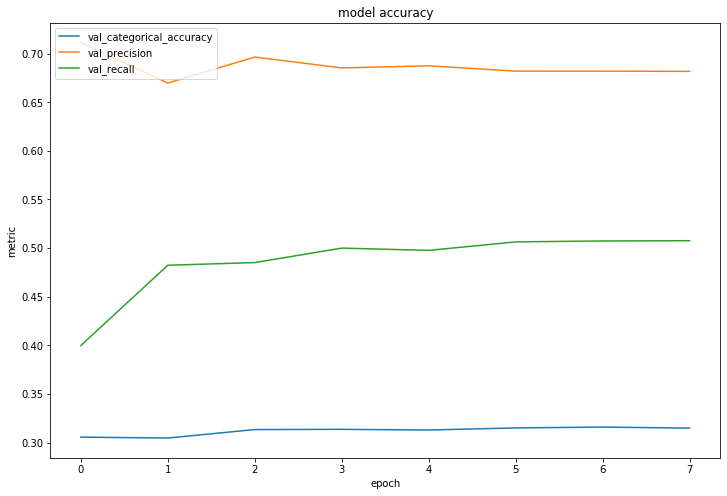

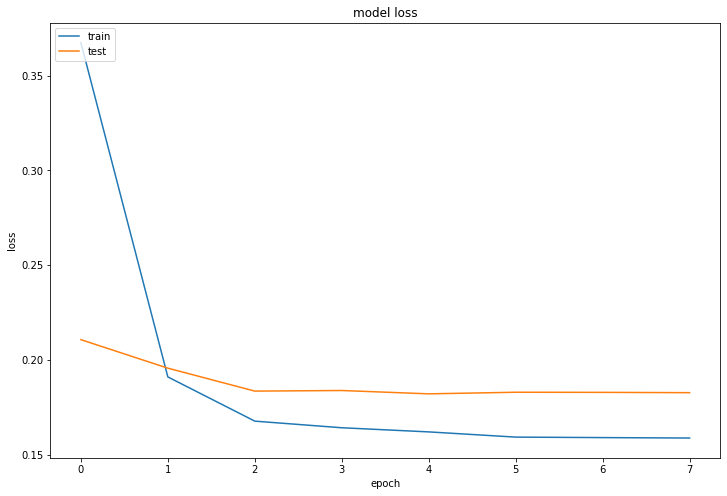

In [26]:
%matplotlib inline

new_history = {}
for key, metrics in history.history.items():
    new_history[lib.utils.fix_metric_name(key)] = metrics

import matplotlib.pyplot as plt


# summarize history for accuracy
fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)

viz_keys = ['val_categorical_accuracy', 'val_precision', 'val_recall']
for key in viz_keys:
    plt.plot(new_history[key])
plt.title('model accuracy')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(viz_keys, loc='upper left')
plt.show()


# summarize history for loss
fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Train a Kim-CNN Model to Label Stack Overflow Questions

Once again we’re ready to train a model to classify/label questions with tag categories. The model is based on [Kim-CNN](https://arxiv.org/abs/1408.5882), a commonly used convolutional neural network for sentence and document classification. We use the functional API and we’ve heavily parametrized the code so as to facilitate experimentation. 

![Kim-CNN Model Architecture](images/kim_cnn_model_architecture.png)

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import (
    Dense, Activation, Embedding, Flatten, MaxPool1D, GlobalMaxPool1D, 
    Dropout, Conv1D, Input, concatenate, Reshape
)
from tensorflow.keras.losses import binary_crossentropy, kld
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


EXPERIMENT_NAME = 'kim_cnn'

FILTER_COUNT        = 128
FILTER_SIZE         = [3, 4, 5, 7]
EPOCHS              = 8
ACTIVATION          = 'selu'
CONV_PADDING        = 'same'
EMBED_SIZE          = 300
EMBED_DROPOUT_RATIO = 0.1
CONV_DROPOUT_RATIO  = 0.1

if len(simple_log) > 0 and EXPERIMENT_NAME == simple_log[-1]['name']:
    print('RENAME YOUR EXPERIMENT')
    raise Exception('RENAME YOUR EXPERIMENT')

SEQUENCE += 1

# # Weights and Biases Monitoring
# import wandb
# from wandb.keras import WandbCallback
# wandb.init(project="weakly-supervised-learning", name=EXPERIMENT_NAME)
# config = wandb.config

# config.update(
#     {
#         'name': EXPERIMENT_NAME,
#         'embedding': 'own',
#         'architecture': 'Kim CNN',
#         'epochs': EPOCHS,
#         'batch_size': BATCH_SIZE,
#         'filter_count': FILTER_COUNT,
#         'filter_size': FILTER_SIZE,
#         'activation': ACTIVATION,
#         'conv_padding': CONV_PADDING,
#         'sequence': SEQUENCE
#     }
# )

padded_input = Input(
    shape=(X_train.shape[1],),
    dtype='int32'
)

emb = Embedding(
    TOKEN_COUNT, 
    EMBED_SIZE,
    embeddings_initializer=RandomUniform(),
    input_length=X_train.shape[1]
)(padded_input)
drp = Dropout(0.1)(emb)

# Create convlutions of different sizes
convs = []
for filter_size in FILTER_SIZE:
    f_conv = Conv1D(
        filters=FILTER_COUNT,
        kernel_size=filter_size,
        padding=CONV_PADDING,
        activation=ACTIVATION
    )(drp)
    f_shape = Reshape((MAX_LEN * EMBED_SIZE, 1))(f_conv)
    f_pool = MaxPool1D(filter_size)(f_conv)
    convs.append(f_pool)

l_merge = concatenate(convs, axis=1)
l_conv = Conv1D(
    128,
    5,
    activation=ACTIVATION
)(l_merge)
l_pool = GlobalMaxPool1D()(l_conv)
l_flat = Flatten()(l_pool)
l_drp  = Dropout(CONV_DROPOUT_RATIO)(l_flat)
l_dense = Dense(
    60,
    activation=ACTIVATION
)(l_drp)
out_dense = Dense(
    y_train.shape[1],
    activation='sigmoid'
)(l_dense)

model = Model(inputs=padded_input, outputs=out_dense)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalseNegatives(),
    ]
)
model.summary()

callbacks = [
    ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        factor=0.1,
        patience=1,
        verbose=1,
    ), 
    EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=2,
        verbose=1,
    ), 
    ModelCheckpoint(
        filepath='models/cnn_tagger.weights.hdf5',
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=1,
    ),
    # WandbCallback()
]

history = model.fit(X_train, y_train,
                    class_weight=train_class_weights,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 200, 300)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 200, 128)     115328      dropout_3[0][0]                  
______________________________________________________________________________________________

Epoch 00004: early stopping


In [28]:
model = tf.keras.models.load_model('models/cnn_tagger.weights.hdf5')
metrics = model.evaluate(X_test, y_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
log = {}
for name, val in zip(model.metrics_names, metrics):
    
    repeat_name, py_val = lib.utils.fix_metric(name, val)
    log[repeat_name] = py_val

# Add a name and sequence number and an F1 score
log.update({'name': EXPERIMENT_NAME})
log.update({'sequence': SEQUENCE})
log.update({'f1': (log['precision'] * log['recall']) / (log['precision'] + log['recall'])})

simple_log.append(log)

# Overwrite the old log
with open('simple_log.jsonl', 'w') as f:
    [f.write(json.dumps(l) + '\n') for l in simple_log]

pd.DataFrame([log])

,auc,categorical_accuracy,f1,false_negatives,false_positives,loss,name,precision,recall,sequence,true_negatives,true_positives
0,0.955897,0.326309,0.263988,776346.0,155021.0,0.009053,kim_cnn,0.770646,0.401535,4,360750560.0,520882.0


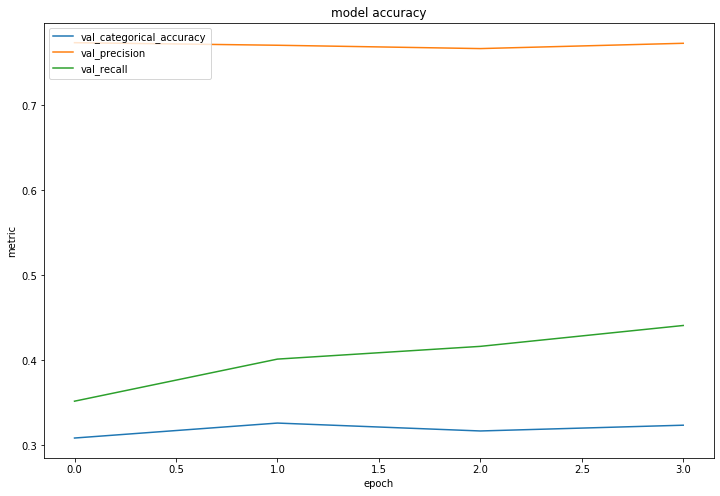

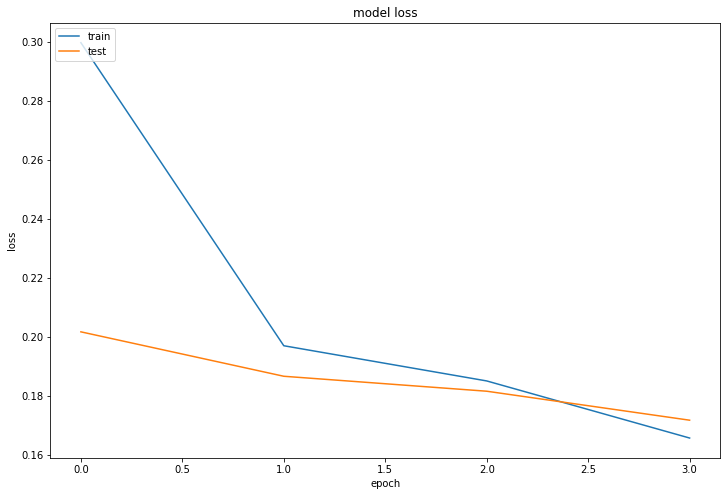

In [30]:
%matplotlib inline

new_history = {}
for key, metrics in history.history.items():
    new_history[lib.utils.fix_metric_name(key)] = metrics

import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)

viz_keys = ['val_categorical_accuracy', 'val_precision', 'val_recall']
# summarize history for accuracy
for key in viz_keys:
    plt.plot(new_history[key])
plt.title('model accuracy')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(viz_keys, loc='upper left')
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Compare this Run to the 1st and Previous Run

To get an idea of performance we need to see where we started and where we just came from.

In [31]:
# Compare to original
if len(simple_log) > 1:
    d2 = simple_log[-1]
    d1 = simple_log[0]
else:
    d1 = simple_log[0]
    d2 = simple_log[0]
log_diff_1 = {key: d2.get(key, 0) - d1.get(key, 0) for key in d1.keys() if key not in ['name', 'sequence']}
log_diff_1['current'] = d2['name']
log_diff_1['previous'] = d1['name']

# Compare to last run
if len(simple_log) > 1:
    d1 = simple_log[-2]
    d2 = simple_log[-1]
else:
    d1 = simple_log[0]
    d2 = simple_log[0]
    
log_diff_2 = {key: d2.get(key, 0) - d1.get(key, 0) for key in d1.keys() if key not in ['name', 'sequence']}
log_diff_2['current'] = d2['name']
log_diff_2['previous'] = d1['name']

df = pd.DataFrame.from_dict([log_diff_1, log_diff_2])
cols = df.columns.tolist()
cols.remove('previous')
cols.remove('current')
show_cols = ['previous', 'current'] + cols
df[show_cols]

,previous,current,auc,categorical_accuracy,f1,false_negatives,false_positives,loss,precision,recall,true_negatives,true_positives
0,simple_cnn_again,kim_cnn,-0.012163,0.011035,-0.026955,137386.0,-152020.0,0.000185,0.088721,-0.105907,164160.0,-137386.0
1,simple_cnn_again,kim_cnn,-0.012163,0.011035,-0.026955,137386.0,-152020.0,0.000185,0.088721,-0.105907,164160.0,-137386.0


## View the Last 10 Experiments

It can be helpful to see trends of performance among experiments.

In [33]:
log_df = pd.DataFrame(simple_log)
log_df['f1'] = (log_df['precision'] * log_df['recall']) / (log_df['precision'] + log_df['recall'])

log_df[[
    'sequence',
    'name',
    'loss',
    'categorical_accuracy',
    'precision',
    'recall',
    'f1',
    'auc',
    'true_positives',
    'false_positives',
    'true_negatives',
    'false_negatives',
]][0:10 if len(log_df) > 9 else len(log_df)]

,sequence,name,loss,categorical_accuracy,precision,recall,f1,auc,true_positives,false_positives,true_negatives,false_negatives
0,3,simple_cnn_again,0.008868,0.315273,0.681925,0.507442,0.290942,0.968060,658268.0,307041.0,360586400.0,638960.0
1,4,kim_cnn,0.009053,0.326309,0.770646,0.401535,0.263988,0.955897,520882.0,155021.0,360750560.0,776346.0


## Check the Actual Prediction Outputs

It is not enough to know theoretical performance. We need to see the actual output of the tagger at different confidence thresholds.

In [34]:
TEST_COUNT = 1000

X_test_text = tokenizer.sequences_to_texts(X_test[:TEST_COUNT])

y_test_tags = []
for row in y_test[:TEST_COUNT].tolist():
    tags = [index_tag[str(i)] for i, col in enumerate(row) if col == 1]
    y_test_tags.append(tags)

## Adjust the threshold for classification

This lets us see how well the model generalizes to labeling more classes.

In [35]:
CLASSIFY_THRESHOLD = 0.5

y_pred = model.predict(X_test)
y_pred = (y_pred > CLASSIFY_THRESHOLD) * 1

y_pred_tags = []
for row in y_pred[:TEST_COUNT].tolist():
    tags = [index_tag[str(i)] for i, col in enumerate(row) if col > CLASSIFY_THRESHOLD]
    y_pred_tags.append(tags)

## See How Far off we are per Class

In [36]:
np.around(y_pred, 0).sum(axis=0) - y_test.sum(axis=0)

array([  -268, -11403,   -845,   -976,   -167,   -411,   -468,   -339,
           20,    302,   -146,  -2371,    -61,  -2185,   -326,   -175,
         -793, -11386,   -342,   -853,   -198,    -72,     42,    272,
            8,   -824,   -802,   -594,     46,    -55,   -760,     17,
        -1184,    282,  -1431,   -280,   -478,   -436,    -38,     -7,
         -978,     43,   -233,    352,  -1930,   -255,   -992,    -57,
         -335,   -266,    -85,  -4113,   -184,  -6563,    -79,    -76,
        -4623,   -621,  -1357,   -907,   -671,   -730,   -423,    178,
         -915,   -515,   -383,  -1769,   -326,    511,   -780,      7,
          -71,   -266,   -171,   -513,  -1853,   -654,     22,   -384,
         -437,      0,   -307,   -121,   -342,    368,  -1133,  -1392,
         -812,  -5835, -32240,  -1126, -15121,  -1964,   -784,   -513,
         -678,    -82,   -205,   -512,   -267,   -261,    -92,   -584,
         -116,   -556,   -565,     22,   -352,    350,  -1943,   -190,
      

### View Prediction Results

It is better to view the results in a DataFrame.

In [37]:
prediction_tests = []
for x, y, z in zip(X_test_text, y_pred_tags, y_test_tags):
    prediction_tests.append({
        'Question': x,
        'Actual': ' '.join(sorted(z)),
        'Predictions': ' '.join(sorted(y)),
    })

pd.set_option('display.max_colwidth', 300)
pd.DataFrame(prediction_tests)[['Question', 'Actual', 'Predictions']]

,Question,Actual,Predictions
0,postgresql query optimization no inner outer join allowed i given query optimize postgresql 9 2 as part school assignment i created indexes respective table __PAD__ b tree __PAD__ b tree primary index the weird part postgresql sequential scan items categories bids table set index search turns __...,database join postgresql,postgresql
1,__PAD__ axis values __PAD__ instead 0 2 i got __PAD__ contains mostly values 0 1 linux load __PAD__ sometimes graph displays axis 0 1 0 2 0 9 that way i want but times i see following __PAD__ __PAD__ is way force displaying 0 1 etc values pad pad pad pad pad pad pad pad pad pad pad pad pad pad p...,graph,
2,draw password field way draw ember textfield ember view handlebars draw text field view em textfield way draw password input field pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad p...,asp.net-mvc ember.js,ember.js
3,what proper method stop loading flex module completely loaded i seem recall loader unload could used stop loading swf finished loading i longer find documentation blog i read perhaps __PAD__ feature anyhow __PAD__ returned __PAD__ __PAD__ unload method if i want halt loading flex module progress...,flex module,flex
4,an example parallel programming multithreading so i think i understand overview concept parallel programming multithreading i wondering achieve multi process multi threaded applications if makes sense looking descriptions multi threading run one processor process multiple cores using parallel al...,c# multithreading parallel-processing,multithreading parallel-processing pthreads
5,what intellij stroke already used i issue intellij many others intellij idea __PAD__ comment work scala having german keyboard i cannot use __PAD__ commenting i would like use different stroke two commenting shortcuts using keyboard i cannot use __PAD__ i one however i cannot find stroke combina...,intellij-idea scala,intellij-idea
6,azure blob storage gui client linux is gui based client azure blob storage run linux i found many client runs windows couple web based clients i looking something like azure explorer pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad p...,azure,azure
7,error multiple if else i new asp development this source code but code i get __PAD__ de compilation microsoft vbscript error __PAD__ __PAD__ instruction __PAD__ __PAD__ common 500 100 asp line 11 dim __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ dim __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ de c...,asp-classic vbscript,asp-classic
8,how i retrieve object id julia in julia say i variable forgotten name i retrieve object using id i e i want inverse pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad ...,julia,julia
9,check see button __PAD__ within function jquery i trying figure way check function checked see button pressed if button pressed display something its bit complicated so i previous next button depending currently displayed prev next functionality change everything shown hide i cant use back histo...,function jquery,button jquery


## The Big Finish

That is the big finish!